### In this notebook, we demonstrate the 'Strong Generalization' phenomenon of diffusion models, that is, diffusion models trained on non-overlapping datasets generate nearly identical images. This phenomenon is previously observed for diffusion models trained on sufficiently large dataset. Our study demonstrates that (i) when this happens, the generated images of diffusion models share structural similarity with those generated from the Gaussian models, which implies the Gaussian structure plays an important role in the generalizability of diffusion models and (ii) decrasing model scale and early stopping the training process can prompt strong generalization, though in this case the generated images have lower quality. 

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import zipfile
import PIL.Image
import json
import matplotlib.pyplot as plt
import dnnlib
import pickle
from training.optim import OptimEDM
#from tqdm import tqdm
import tqdm
try:
    import pyspng
except ImportError:
    pyspng = None
import torch.nn.init as init
from knn_finder import *

### Some basic helper functions

In [3]:
def file_ext(fname):
    return os.path.splitext(fname)[1].lower()

def load_ffhq_zip(zip_path):
    zip_file = zipfile.ZipFile(zip_path)
    all_names = set(zip_file.namelist())

    PIL.Image.init()
    image_names = sorted(fname for fname in all_names if file_ext(fname) in PIL.Image.EXTENSION)

    images = []    
    # load images
    for name in image_names:
        with zip_file.open(name, 'r') as f:
            if pyspng is not None and file_ext(name) == '.png':
                image = pyspng.load(f.read())
            else:
                image = np.array(PIL.Image.open(f))
        if image.ndim == 2:
            image = image[:, :, np.newaxis]  # HW => HWC
        image = image.transpose(2, 0, 1)     # HWC => CHW

        # append images
        images.append(image[np.newaxis, :, :, :])

    images = np.concatenate(images, axis=0)
    N, C, H, W = images.shape
    y = torch.from_numpy(images).to(torch.float32) / 127.5 - 1
    y = y.reshape(N, C*H*W)
    return y

def load_img_zip(zip_path):
    zip_file = zipfile.ZipFile(zip_path)
    all_names = set(zip_file.namelist())

    PIL.Image.init()
    image_names = sorted(fname for fname in all_names if file_ext(fname) in PIL.Image.EXTENSION)

    images = []    
    # load images
    for name in tqdm.tqdm(image_names):
        with zip_file.open(name, 'r') as f:
            if pyspng is not None and file_ext(name) == '.png':
                image = pyspng.load(f.read())
            else:
                image = np.array(PIL.Image.open(f))
        if image.ndim == 2:
            image = image[:, :, np.newaxis]  # HW => HWC
        image = image.transpose(2, 0, 1)     # HWC => CHW

        # append images
        images.append(image[np.newaxis, :, :, :])

    images = np.concatenate(images, axis=0)
    N, C, H, W = images.shape
    #y = torch.from_numpy(images).to(torch.float32) / 127.5 - 1
    y = images / 127.5 - 1
    y = y.reshape(N, -1)
    y = np.float32(y)
    return y

def normalize_img(img):
    img = img-torch.min(img)
    img = img/torch.max(img)
    return img

def torch_to_np(img):
    img = img.detach().cpu()[0].permute(1,2,0).numpy()
    return img

def normalize_img_np(img):
    img = img-np.min(img)
    img = img/np.max(img)
    return img

def get_denoised_img(noisy_img, net, var, device=torch.device('cuda')):
    # variance should be in the range(0.002,80)
    return net(noisy_img, torch.tensor(var,device=device))

def get_dataloader(data_path, batch_size):
    c = dnnlib.EasyDict()
    c.dataset_kwargs = dnnlib.EasyDict(class_name='training.dataset.ImageFolderDataset', path=data_path, use_labels=False, xflip=False, cache=True)
    c.data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, num_workers=1, prefetch_factor=2)
    dataset_obj = dnnlib.util.construct_class_by_name(**c.dataset_kwargs) # subclass of training.dataset.Dataset
    dataloader = torch.utils.data.DataLoader(dataset=dataset_obj, batch_size=batch_size, shuffle=False)
    return dataset_obj

def custom_sort(string):
    return float(string)

### Define the Multivariate Gaussian denoiser and samplers

In [4]:
# Gaussian model
class multi_gaussian(nn.Module):
    def __init__(self, mean, covariance,low_rank):
        super(multi_gaussian, self).__init__()
        self.mean = mean.to(torch.float64)
        self.U, self.S, self.Vh = covariance
        self.U = self.U[:,:low_rank].clone().to(torch.float64)
        self.S = self.S[:low_rank].clone().to(torch.float64)
        self.Vh = self.Vh[:low_rank,:].clone().to(torch.float64)
    def forward(self, x, sigma):
        S = self.S/(self.S + sigma**2)
        I = torch.eye(self.U.shape[0], device=self.U.device, dtype=self.U.dtype)
        x = x.flatten(start_dim = 1)
        out = torch.mm(self.Vh, (x - self.mean).t())
        out = torch.mm(torch.diag(S),out)
        return (self.mean + torch.mm(self.U, torch.mm(torch.diag(S), torch.mm(self.Vh, (x - self.mean).t()))).t())

# This function is used to sample images from EDM model, we use the simple first order sampler.    
def generate_image(
    net, latents ,even_t=False, num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1, device=torch.device('cuda')):
    sigma_list = []
    intermediates = []
    denoised_intermediates = []
    
    # Pick latents and labels.
    batch_size = latents.shape[0]
    class_labels = None
    if net.label_dim:
        class_labels = torch.eye(net.label_dim, device=device)[torch.randint(net.label_dim, size=[batch_size], device=device)]

    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    if even_t == True:
        t_steps = torch.from_numpy(np.linspace(sigma_max, sigma_min, num_steps)).to(device)
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    for i, (t_cur, t_next) in tqdm.tqdm(list(enumerate(zip(t_steps[:-1], t_steps[1:]))), unit='step'): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * torch.randn_like(x_cur)

        # Euler step.
        denoised = net(x_hat, t_hat, class_labels).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur
        '''
        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        '''
        intermediates.append(x_cur.detach().cpu())
        denoised_intermediates.append(denoised.detach().cpu())
        sigma_list.append(t_cur.item())
        
    # Save image grid.
    return sigma_list, intermediates, denoised_intermediates

# This function is used to sample images from Gaussian model, we use the simple first order sampler.    
def generate_image_Gaussian(
    net, Gaussian_net, latents ,even_t=False, num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1, device=torch.device('cuda')):
    sigma_list = []
    intermediates = []
    denoised_intermediates = []
    
    # Pick latents and labels.
    batch_size = latents.shape[0]
    class_labels = None
    if net.label_dim:
        class_labels = torch.eye(net.label_dim, device=device)[torch.randint(net.label_dim, size=[batch_size], device=device)]

    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    if even_t == True:
        t_steps = torch.from_numpy(np.linspace(sigma_max, sigma_min, num_steps)).to(device)
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    for i, (t_cur, t_next) in tqdm.tqdm(list(enumerate(zip(t_steps[:-1], t_steps[1:]))), unit='step'): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * torch.randn_like(x_cur)

        # Euler step.
        denoised = Gaussian_net(x_hat, t_hat).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur
        '''
        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        '''
        intermediates.append(x_cur.detach().cpu())
        denoised_intermediates.append(denoised.detach().cpu())
        sigma_list.append(t_cur.item())
        
    # Save image grid.
    return sigma_list, intermediates, denoised_intermediates

### 1. We first present the results for FFHQ dataset

### We first investigate strong generalization under large dataset size. We split the FFHQ dataset into subsets S1 and S2. Each of them has 35000 images (the total number of images in FFHQ dataset is 70000). The diffusion models used here have scale 128.

In [94]:
torch.manual_seed(0)

# Prepare the training datasets 
device = torch.device('cuda')
data_path_s1 = 'datasets/ffhq-35000-set1.zip'
data_path_s2 = 'datasets/ffhq-35000-set2.zip'
dataset_ffhq_s1 = load_ffhq_zip(data_path_s1)
dataset_ffhq_s2 = load_ffhq_zip(data_path_s2)

# Construct the class for finding nearest neighbors
nn_finder_s1 = KnnFinder(data_path_s1)
nn_finder_s2 = KnnFinder(data_path_s2)

# Constrcut the diffusion models
net_final_pkl_s1 = 'Strong_Generalization_Weights/FFHQ/35000-set1/network-snapshot-070246.pkl'
net_final_pkl_s2 = 'Strong_Generalization_Weights/FFHQ/35000-set2/network-snapshot-070246.pkl'

with dnnlib.util.open_url(net_final_pkl_s1) as f:
    net_final_s1 = pickle.load(f)['ema'].to(device)
    
with dnnlib.util.open_url(net_final_pkl_s2) as f:
    net_final_s2 = pickle.load(f)['ema'].to(device)

load ffhq


100%|██████████| 35000/35000 [00:01<00:00, 19801.89it/s]


load ffhq


100%|██████████| 35000/35000 [00:01<00:00, 18310.52it/s]


In [95]:
# Construct the Gaussian model from S1
imgs = load_ffhq_zip(data_path_s1)
mean = torch.mean(imgs, dim=0)
temp = imgs-mean
covariance = temp.T@temp/temp.shape[0]
covariance = covariance.to(device)
U,S,Vh = torch.linalg.svd(covariance, full_matrices=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
mean = mean.to(device)


# You can save those data for later use
'''
save_dir = 'Covariance_FFHQ/35000_s1/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
torch.save(mean, os.path.join(save_dir,'mean.pt'))
torch.save((U,S,Vh), os.path.join(save_dir,'covariance.pt'))
'''

Gaussian_model_s1 = multi_gaussian(mean, (U, S, Vh),3*64*64).to(device)

# Construct the Gaussian model from S2
imgs = load_ffhq_zip(data_path_s2)
mean = torch.mean(imgs, dim=0)
temp = imgs-mean
covariance = temp.T@temp/temp.shape[0]
covariance = covariance.to(device)
U,S,Vh = torch.linalg.svd(covariance, full_matrices=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
mean = mean.to(device)


# You can save those data for later use
'''
save_dir = 'Covariance_FFHQ/35000_s2/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
torch.save(mean, os.path.join(save_dir,'mean.pt'))
torch.save((U,S,Vh), os.path.join(save_dir,'covariance.pt'))
'''

Gaussian_model_s2 = multi_gaussian(mean, (U, S, Vh),3*64*64).to(device)

### Generate images from Gaussian models and EDMs

In [116]:
device = torch.device('cuda')
torch.manual_seed(0)
latents = torch.randn(10,3,64,64).to(device)
num_steps = 10
rank = 3*64*64

# Generate images with nonlinear diffusion models
sigma_list, intermediates_35000_s1, denoised_intermediates_35000_s1 = generate_image(net_final_s1, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_35000_s2, denoised_intermediates_35000_s2 = generate_image(net_final_s2, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)


# Generate images with linear Gaussian diffusion models
sigma_list, intermediates_Gaussian_35000_s1, denoised_intermediates_Gaussian_35000_s1 = generate_image_Gaussian(net_final_s1, Gaussian_model_s1, latents.reshape(-1,3*64*64) ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_Gaussian_35000_s2, denoised_intermediates_Gaussian_35000_s2 = generate_image_Gaussian(net_final_s2, Gaussian_model_s2, latents.reshape(-1,3*64*64) ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)


# Finding the nearest neighbors
denoised_35000_s1 = torch.stack(denoised_intermediates_35000_s1)[-1].cuda()
descending_index, _ = nn_finder_s1(denoised_35000_s1, sigma=torch.tensor(1).to(device)) # here sigma is a dummy input, it can be set to any positive value
nn_35000_s1 = dataset_ffhq_s1[descending_index[:,0],:]

denoised_35000_s2 = torch.stack(denoised_intermediates_35000_s2)[-1].cuda()
descending_index, _ = nn_finder_s2(denoised_35000_s2, sigma=torch.tensor(1).to(device))
nn_35000_s2 = dataset_ffhq_s2[descending_index[:,0],:]

100%|██████████| 10/10 [00:01<00:00,  7.38step/s]


### Below we visualize the strong generalization phenomenon. Notice that the two diffusion models (EDM) generate nearly-identical images, which implies diffusion models in the strong generalization regime extract and utilize certain common shared information of the two non-overlapping datasets S1 and S2 for image generation. We argue such shared information can be partially attributed to the Gaussian structure. As shown below, the two Gaussian models generate nearly-identical images, indicating S1 and S2 have nearly-identical Gaussian structure. Furthermore, the Gaussian models generate samples that match those generated by the nonlinear diffusion models, indicating the Gaussian structure plays an important role in the generalization of EDM.

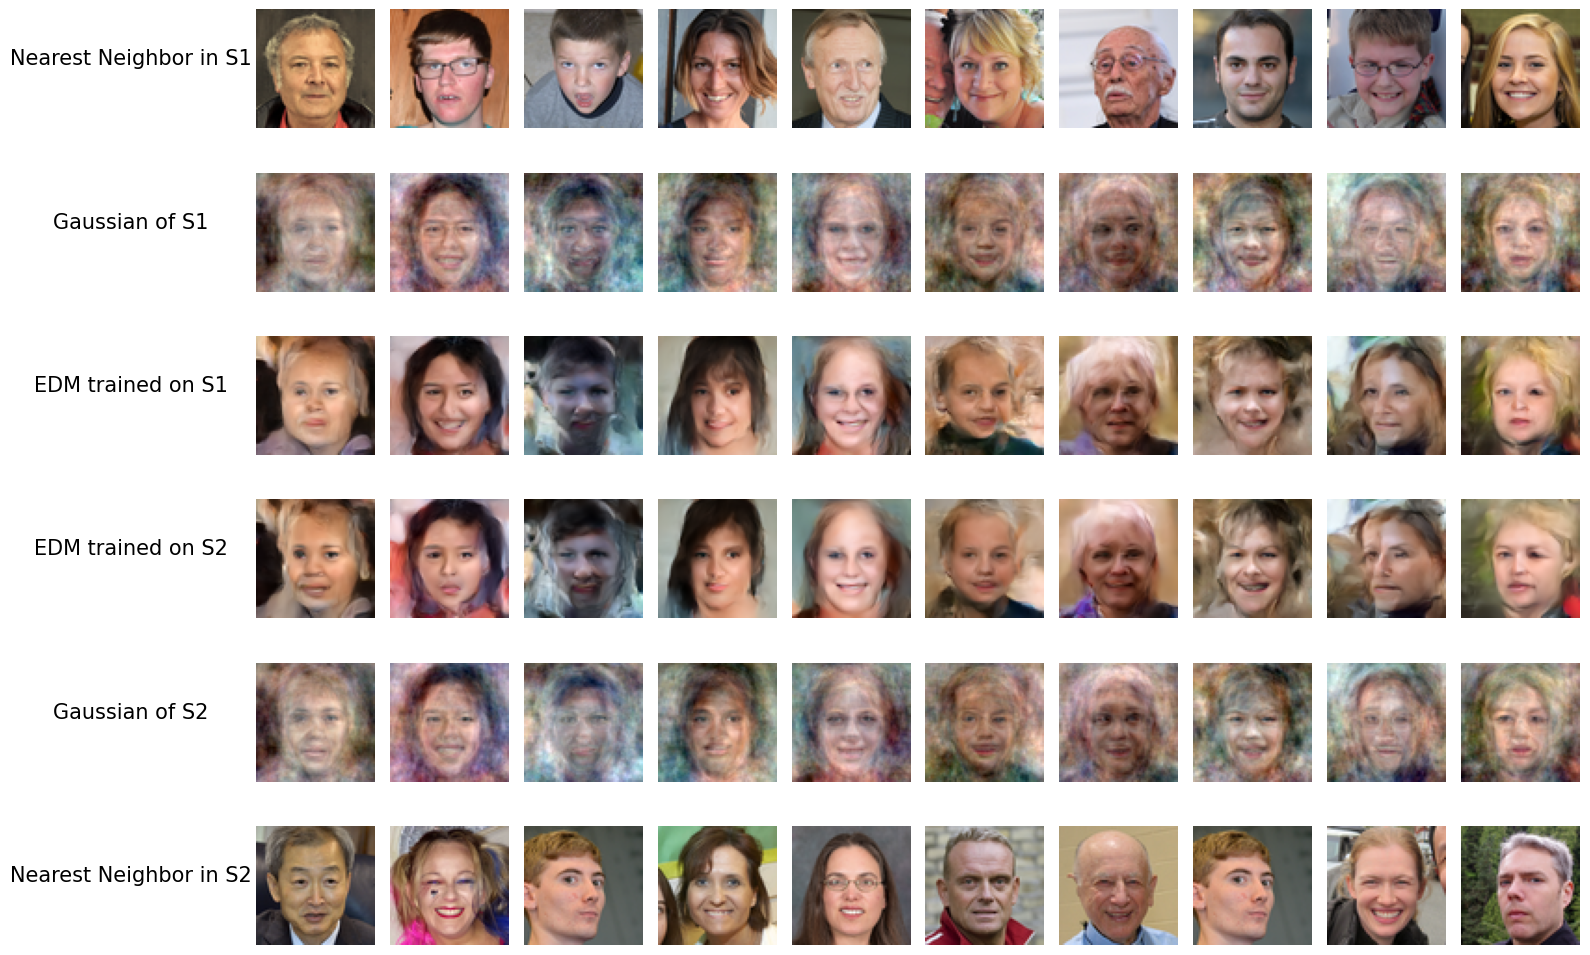

In [117]:
labelpad_value = 90
plt.figure(figsize=(16,10))
num_show = 10 #10
idx_list = range(num_show)
fontsize = 15
#idx_list = range(60,70)
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1)
    plt.imshow(normalize_img(nn_35000_s1[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_35000_s1[-4][idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+2*num_show)
    plt.imshow(normalize_img(denoised_35000_s1[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S1', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 

for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+3*num_show)
    plt.imshow(normalize_img(denoised_35000_s2[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+4*num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_35000_s2[-4][idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+5*num_show)
    plt.imshow(normalize_img(nn_35000_s2[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S2',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
plt.tight_layout()

### However, if we keep the model capacity unchanged (scale 128) but decrease the training dataset size such that S1 and S2 contain 1094 images each, the diffusion models will enter the memorization regime and unable to generate novel images.

In [118]:
torch.manual_seed(0)

# prepare the non-overlapping dataset
device = torch.device('cuda')
data_path_s1 = 'datasets/ffhq-1094-set1.zip'
data_path_s2 = 'datasets/ffhq-1094-set2.zip'
dataset_ffhq_s1 = load_ffhq_zip(data_path_s1)
dataset_ffhq_s2 = load_ffhq_zip(data_path_s2)

net_final_pkl_s1 = 'Strong_Generalization_Weights/FFHQ/1094-set1-scale-128/network-snapshot-070246.pkl'
net_final_pkl_s2 = 'Strong_Generalization_Weights/FFHQ/1094-set2-scale-128/network-snapshot-070246.pkl'

# Construct the class for finding nearest neighbors
nn_finder_s1 = KnnFinder(data_path_s1)
nn_finder_s2 = KnnFinder(data_path_s2)

with dnnlib.util.open_url(net_final_pkl_s1) as f:
    net_final_s1 = pickle.load(f)['ema'].to(device)
    
with dnnlib.util.open_url(net_final_pkl_s2) as f:
    net_final_s2 = pickle.load(f)['ema'].to(device)

load ffhq


100%|██████████| 1094/1094 [00:00<00:00, 21426.79it/s]


load ffhq


100%|██████████| 1094/1094 [00:00<00:00, 21025.81it/s]


In [106]:
# Construct the Gaussian model from S1
imgs = load_ffhq_zip(data_path_s1)
mean = torch.mean(imgs, dim=0)
temp = imgs-mean
covariance = temp.T@temp/temp.shape[0]
covariance = covariance.to(device)
U,S,Vh = torch.linalg.svd(covariance, full_matrices=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
mean = mean.to(device)


# You can save those data for later use
'''
save_dir = 'Covariance_FFHQ/1094_s1/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
torch.save(mean, os.path.join(save_dir,'mean.pt'))
torch.save((U,S,Vh), os.path.join(save_dir,'covariance.pt'))
'''

Gaussian_model_s1 = multi_gaussian(mean, (U, S, Vh),3*64*64).to(device)

# Construct the Gaussian model from S2
imgs = load_ffhq_zip(data_path_s2)
mean = torch.mean(imgs, dim=0)
temp = imgs-mean
covariance = temp.T@temp/temp.shape[0]
covariance = covariance.to(device)
U,S,Vh = torch.linalg.svd(covariance, full_matrices=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
mean = mean.to(device)


# You can save those data for later use
'''
save_dir = 'Covariance_FFHQ/1094_s2/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
torch.save(mean, os.path.join(save_dir,'mean.pt'))
torch.save((U,S,Vh), os.path.join(save_dir,'covariance.pt'))
'''

Gaussian_model_s2 = multi_gaussian(mean, (U, S, Vh),3*64*64).to(device)

### Generate images from EDM and Gaussian models

In [119]:
device = torch.device('cuda')
torch.manual_seed(0)
latents = torch.randn(10,3,64,64).to(device)
num_steps = 10
rank = 3*64*64

# Generate images with nonlinear diffusion models
sigma_list, intermediates_1094_s1, denoised_intermediates_1094_s1 = generate_image(net_final_s1, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_1094_s2, denoised_intermediates_1094_s2 = generate_image(net_final_s2, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)


# Generate images with linear Gaussian diffusion models
sigma_list, intermediates_Gaussian_1094_s1, denoised_intermediates_Gaussian_1094_s1 = generate_image_Gaussian(net_final_s1, Gaussian_model_s1, latents.reshape(-1,3*64*64) ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_Gaussian_1094_s2, denoised_intermediates_Gaussian_1094_s2 = generate_image_Gaussian(net_final_s2, Gaussian_model_s2, latents.reshape(-1,3*64*64) ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)


# Finding the nearest neighbors
denoised_1094_s1 = torch.stack(denoised_intermediates_1094_s1)[-1].cuda()
descending_index, _ = nn_finder_s1(denoised_1094_s1, sigma=torch.tensor(1).to(device)) # here sigma is a dummy input, it can be set to any positive value
nn_1094_s1 = dataset_ffhq_s1[descending_index[:,0],:]

denoised_1094_s2 = torch.stack(denoised_intermediates_1094_s2)[-1].cuda()
descending_index, _ = nn_finder_s2(denoised_1094_s2, sigma=torch.tensor(1).to(device))
nn_1094_s2 = dataset_ffhq_s2[descending_index[:,0],:]

100%|██████████| 10/10 [00:01<00:00,  7.39step/s]


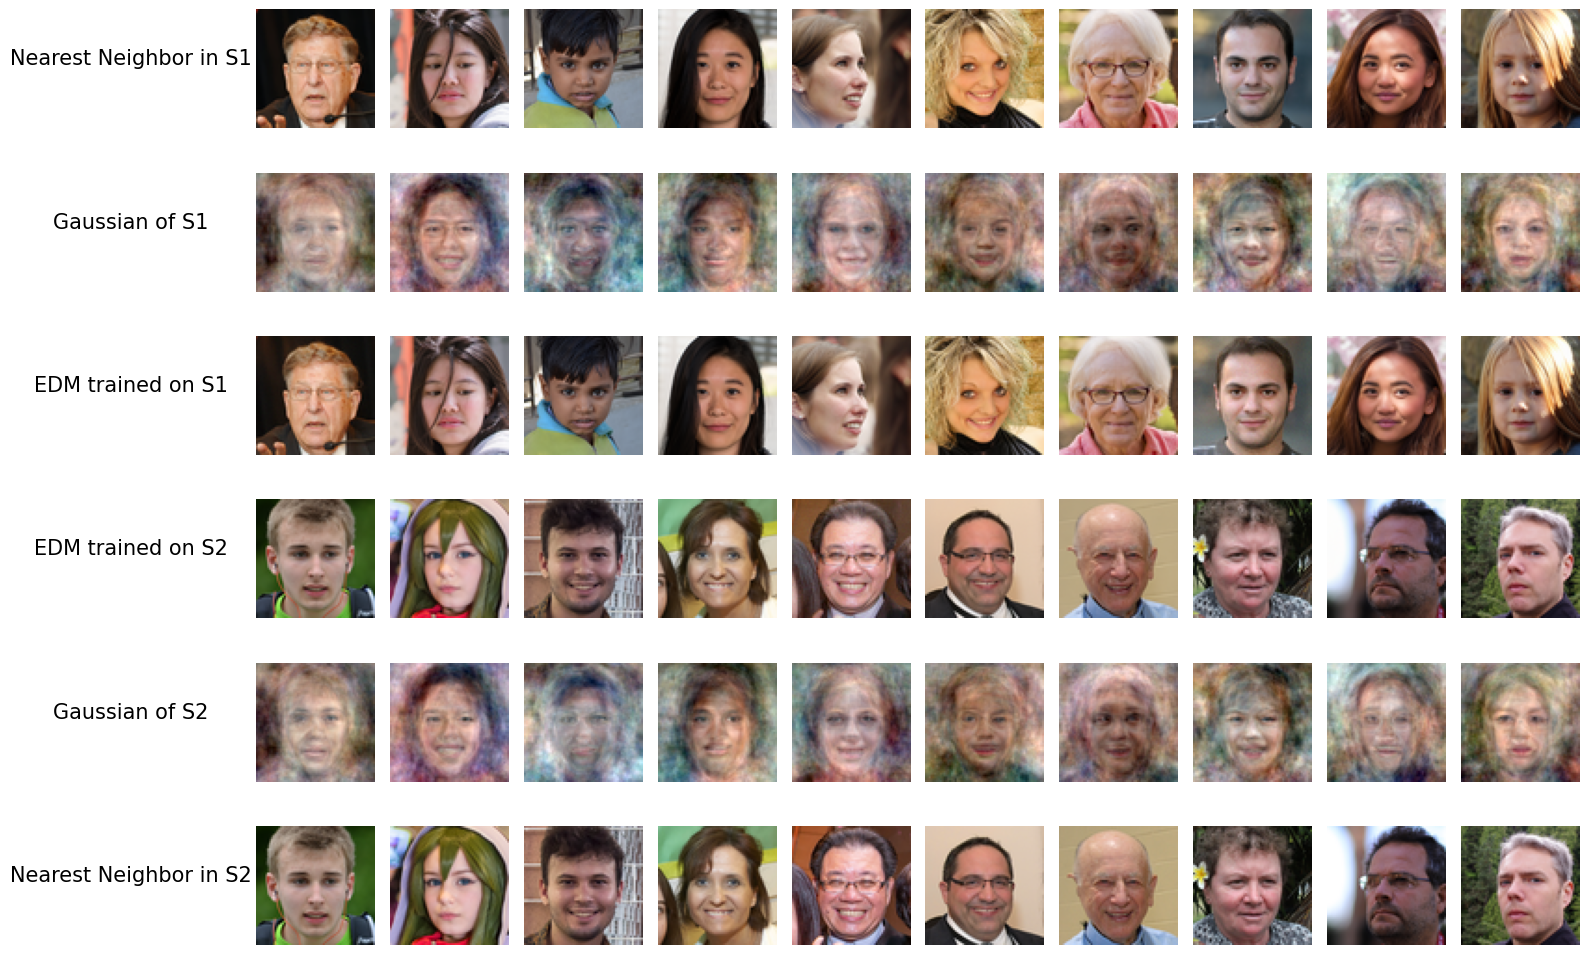

In [120]:
labelpad_value = 90
plt.figure(figsize=(16,10))
num_show = 10 #10
idx_list = range(num_show)
fontsize = 15
#idx_list = range(60,70)
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1)
    plt.imshow(normalize_img(nn_1094_s1[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_1094_s1[-4][idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+2*num_show)
    plt.imshow(normalize_img(denoised_1094_s1[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S1', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 

for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+3*num_show)
    plt.imshow(normalize_img(denoised_1094_s2[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+4*num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_1094_s2[-4][idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+5*num_show)
    plt.imshow(normalize_img(nn_1094_s2[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S2',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
plt.tight_layout()

### Given the important role played by the Gaussian structure in diffusion generalization, can we push the models out of the memorization regime by decreasing the model scale or early stopping the training process? 

### First, we show early stop the training process lead to generalization. The model scale here is kept as 128. 

In [109]:
net_final_pkl_s1 = 'Strong_Generalization_Weights/FFHQ/1094-set1-scale-128/network-snapshot-000921.pkl'

net_final_pkl_s2 = 'Strong_Generalization_Weights/FFHQ/1094-set2-scale-128/network-snapshot-000921.pkl'

with dnnlib.util.open_url(net_final_pkl_s1) as f:
    net_final_s1 = pickle.load(f)['ema'].to(device)
    
with dnnlib.util.open_url(net_final_pkl_s2) as f:
    net_final_s2 = pickle.load(f)['ema'].to(device)

In [110]:
torch.manual_seed(0)
latents = torch.randn(10,3,64,64).to(device)
num_steps = 10
rank = 3*64*64

# Generate images with nonlinear diffusion models
sigma_list, intermediates_1094_s1, denoised_intermediates_1094_s1 = generate_image(net_final_s1, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_1094_s2, denoised_intermediates_1094_s2 = generate_image(net_final_s2, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)


# Finding the nearest neighbors
denoised_1094_s1 = torch.stack(denoised_intermediates_1094_s1)[-1].cuda()
descending_index, _ = nn_finder_s1(denoised_1094_s1, sigma=torch.tensor(1).to(device)) # here sigma is a dummy input, it can be set to any positive value
nn_1094_s1 = dataset_ffhq_s1[descending_index[:,0],:]

denoised_1094_s2 = torch.stack(denoised_intermediates_1094_s2)[-1].cuda()
descending_index, _ = nn_finder_s2(denoised_1094_s2, sigma=torch.tensor(1).to(device))
nn_1094_s2 = dataset_ffhq_s2[descending_index[:,0],:]

100%|██████████| 10/10 [00:00<00:00, 21.14step/s]


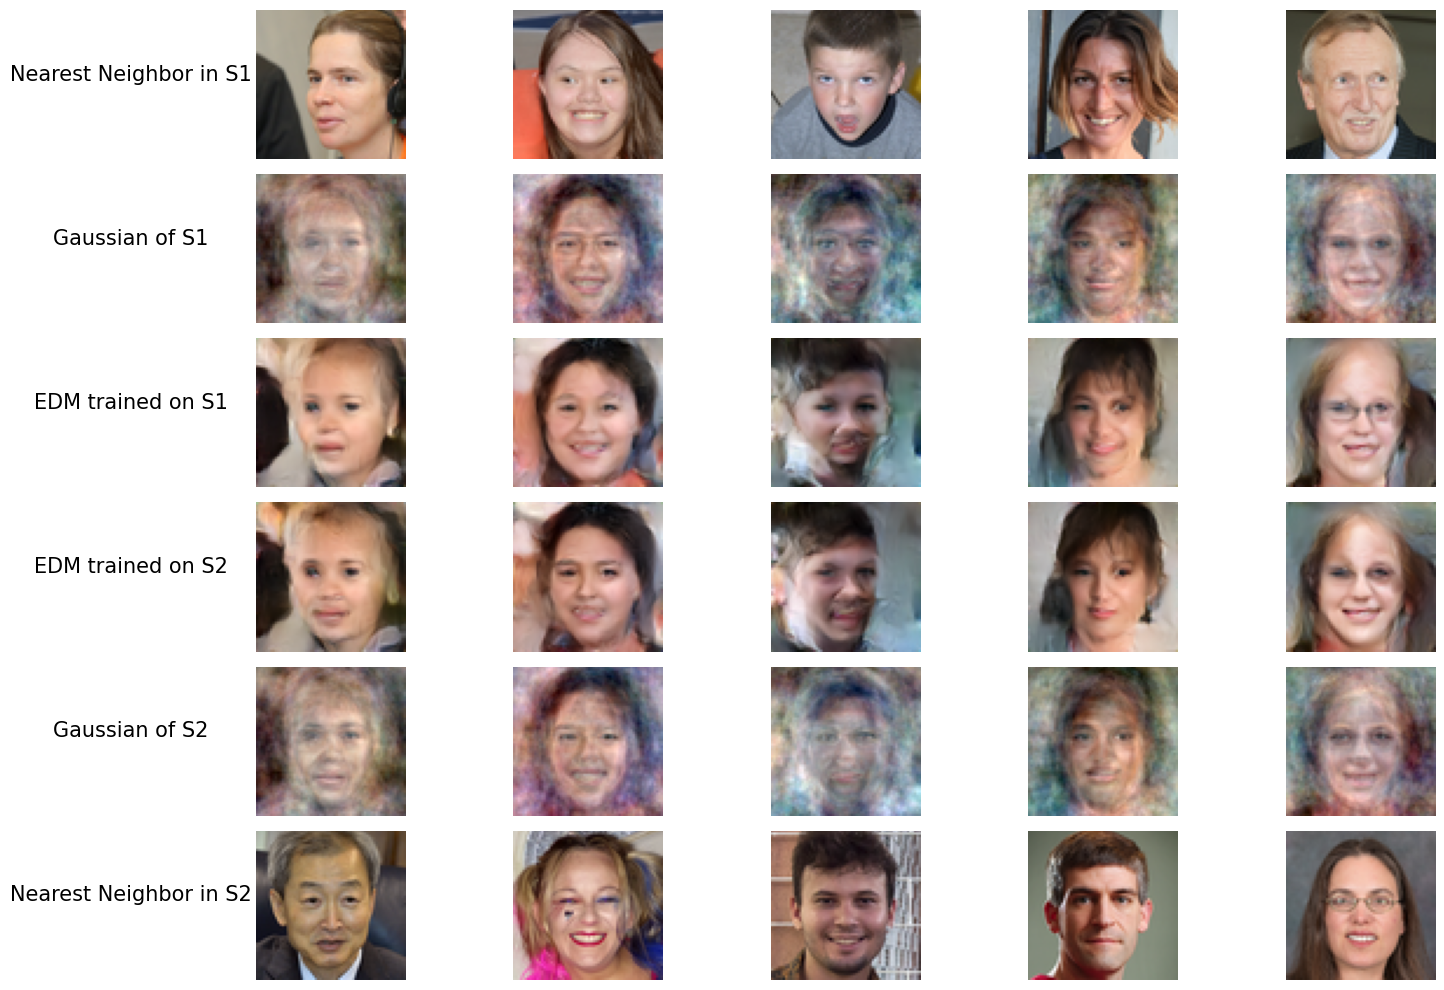

In [112]:
labelpad_value = 90
plt.figure(figsize=(16,10))
num_show = 5
idx_list = range(num_show)
fontsize = 15
#idx_list = range(60,70)
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1)
    plt.imshow(normalize_img(nn_1094_s1[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_1094_s1[-4][idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+2*num_show)
    plt.imshow(normalize_img(denoised_1094_s1[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S1', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 

for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+3*num_show)
    plt.imshow(normalize_img(denoised_1094_s2[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+4*num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_1094_s2[-4][idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+5*num_show)
    plt.imshow(normalize_img(nn_1094_s2[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S2',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
plt.tight_layout()

### Another way to prompt Gaussian structure and generalization is to decrease the model scale. We keep the training dataset size the same (1094) but decrease the model scale from 128 to 8. Notice that in this case diffusion models generalize even after sufficient training (trained over 19000/1094 = 174 epochs in total).

In [113]:
net_final_pkl_s1 = 'Strong_Generalization_Weights/FFHQ/1094-set1-scale-8/network-snapshot-197843.pkl'

net_final_pkl_s2 = 'Strong_Generalization_Weights/FFHQ/1094-set2-scale-8/network-snapshot-198195.pkl'


with dnnlib.util.open_url(net_final_pkl_s1) as f:
    net_final_s1 = pickle.load(f)['ema'].to(device)
    
with dnnlib.util.open_url(net_final_pkl_s2) as f:
    net_final_s2 = pickle.load(f)['ema'].to(device)

In [114]:
torch.manual_seed(0)
latents = torch.randn(10,3,64,64).to(device)
num_steps = 10
rank = 3*64*64

# Generate images with nonlinear diffusion models
sigma_list, intermediates_1094_s1, denoised_intermediates_1094_s1 = generate_image(net_final_s1, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_1094_s2, denoised_intermediates_1094_s2 = generate_image(net_final_s2, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)


# Finding the nearest neighbors
denoised_1094_s1 = torch.stack(denoised_intermediates_1094_s1)[-1].cuda()
descending_index, _ = nn_finder_s1(denoised_1094_s1, sigma=torch.tensor(1).to(device)) # here sigma is a dummy input, it can be set to any positive value
nn_1094_s1 = dataset_ffhq_s1[descending_index[:,0],:]

denoised_1094_s2 = torch.stack(denoised_intermediates_1094_s2)[-1].cuda()
descending_index, _ = nn_finder_s2(denoised_1094_s2, sigma=torch.tensor(1).to(device))
nn_1094_s2 = dataset_ffhq_s2[descending_index[:,0],:]

100%|██████████| 10/10 [00:00<00:00, 41.21step/s]


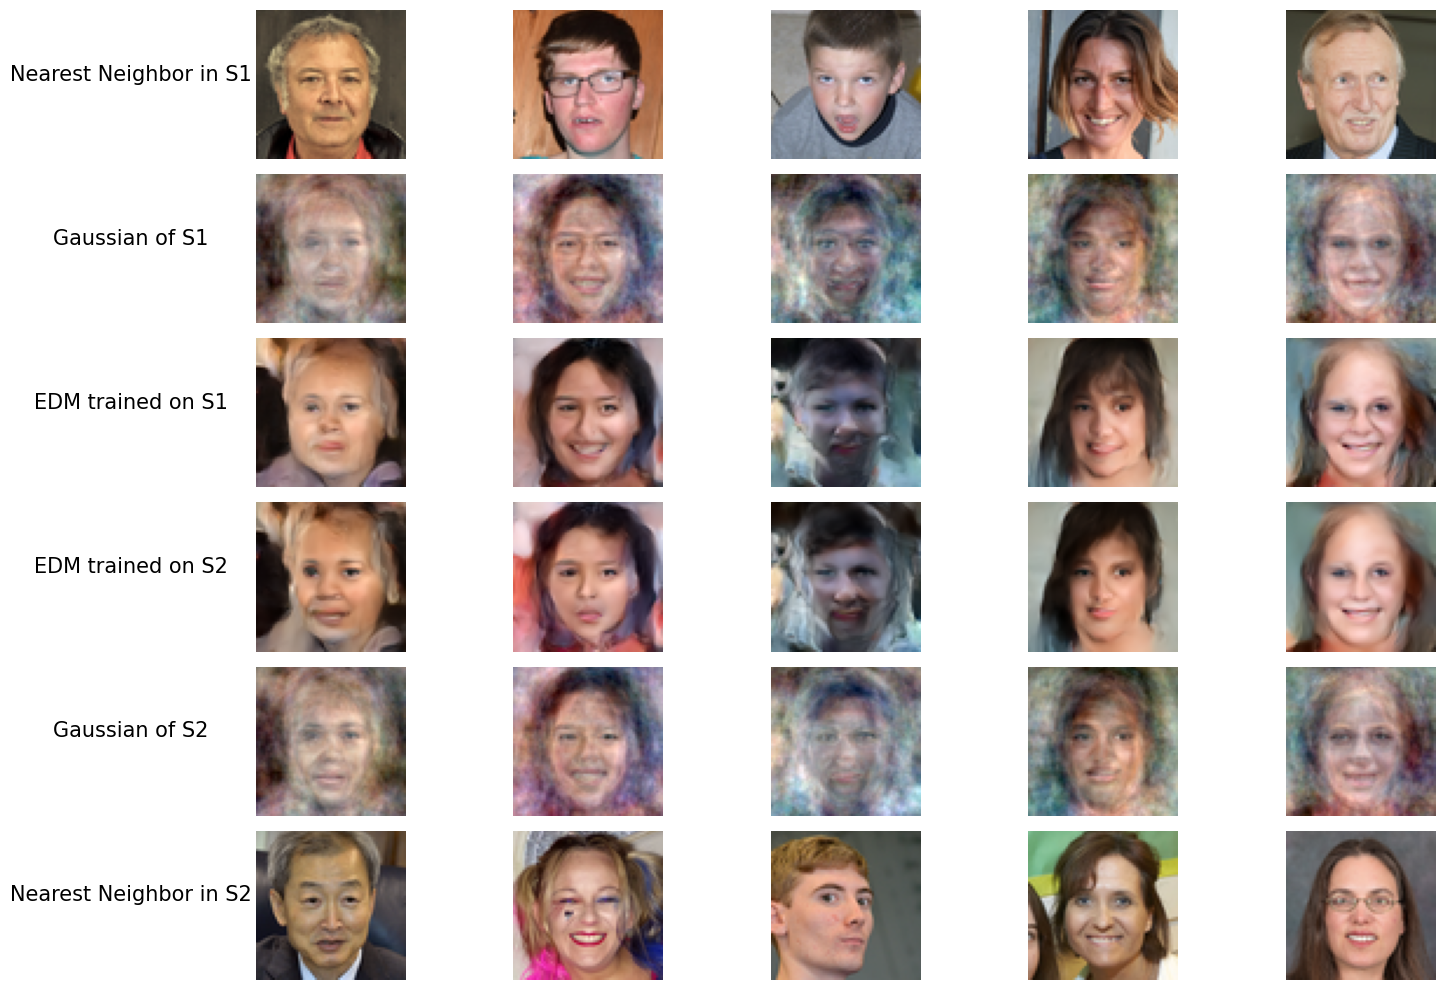

In [115]:
labelpad_value = 90
plt.figure(figsize=(16,10))
num_show = 5
idx_list = range(num_show)
fontsize = 15
#idx_list = range(60,70)
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1)
    plt.imshow(normalize_img(nn_1094_s1[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_1094_s1[-4][idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+2*num_show)
    plt.imshow(normalize_img(denoised_1094_s1[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S1', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 

for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+3*num_show)
    plt.imshow(normalize_img(denoised_1094_s2[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+4*num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_1094_s2[-4][idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+5*num_show)
    plt.imshow(normalize_img(nn_1094_s2[idx].reshape(3,64,64).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S2',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
plt.tight_layout()

### 2. Next, we repeat the same experiments on Cifar-10 dataset.

### We first demonstrate strong generalizability on diffusion models of scale 64 trained on two non-overlapping subsets of Cifar-10. Each subset has 25000 images (Cifar-10 has 50000 images in total).

In [50]:
torch.manual_seed(0)

device = torch.device('cuda')
data_path_s1 = 'datasets/cifar10-25000-set1.zip'
data_path_s2 = 'datasets/cifar10-25000-set2.zip'
dataset_s1 = load_ffhq_zip(data_path_s1)
dataset_s2 = load_ffhq_zip(data_path_s2)

# Construct the class for finding nearest neighbors
nn_finder_s1 = KnnFinder(data_path_s1)
nn_finder_s2 = KnnFinder(data_path_s2)

net_final_pkl_s1 = 'Strong_Generalization_Weights/Cifar/25000-set1-scale-64/network-snapshot-200000.pkl'
net_final_pkl_s2 = 'Strong_Generalization_Weights/Cifar/25000-set2-scale-64/network-snapshot-200000.pkl'

with dnnlib.util.open_url(net_final_pkl_s1) as f:
    net_final_s1 = pickle.load(f)['ema'].to(device)
    
with dnnlib.util.open_url(net_final_pkl_s2) as f:
    net_final_s2 = pickle.load(f)['ema'].to(device)

load ffhq


100%|██████████| 25000/25000 [00:00<00:00, 36433.08it/s]


load ffhq


100%|██████████| 25000/25000 [00:00<00:00, 36539.56it/s]


In [41]:
# Construct the Gaussian model from S1
imgs = load_ffhq_zip(data_path_s1)
mean = torch.mean(imgs, dim=0)
temp = imgs-mean
covariance = temp.T@temp/temp.shape[0]
covariance = covariance.to(device)
U,S,Vh = torch.linalg.svd(covariance, full_matrices=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
mean = mean.to(device)


# You can save those data for later use
'''
save_dir = 'Covariance_Cifar/25000_s1/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
torch.save(mean, os.path.join(save_dir,'mean.pt'))
torch.save((U,S,Vh), os.path.join(save_dir,'covariance.pt'))
'''

Gaussian_model_s1 = multi_gaussian(mean, (U, S, Vh),3*32*32).to(device)

# Construct the Gaussian model from S2
imgs = load_ffhq_zip(data_path_s2)
mean = torch.mean(imgs, dim=0)
temp = imgs-mean
covariance = temp.T@temp/temp.shape[0]
covariance = covariance.to(device)
U,S,Vh = torch.linalg.svd(covariance, full_matrices=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
mean = mean.to(device)


# You can save those data for later use
'''
save_dir = 'Covariance_Cifar/25000_s2/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
torch.save(mean, os.path.join(save_dir,'mean.pt'))
torch.save((U,S,Vh), os.path.join(save_dir,'covariance.pt'))
'''

Gaussian_model_s2 = multi_gaussian(mean, (U, S, Vh),3*32*32).to(device)

### Generate images from EDM and Gaussian models

In [51]:
device = torch.device('cuda')
torch.manual_seed(0)
latents = torch.randn(10,3,32,32).to(device)
num_steps = 10
rank = 3*32*32

# Generate images with nonlinear diffusion models
sigma_list, intermediates_25000_s1, denoised_intermediates_25000_s1 = generate_image(net_final_s1, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_25000_s2, denoised_intermediates_25000_s2 = generate_image(net_final_s2, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)


# Generate images with linear Gaussian diffusion models
sigma_list, intermediates_Gaussian_25000_s1, denoised_intermediates_Gaussian_25000_s1 = generate_image_Gaussian(net_final_s1, Gaussian_model_s1, latents.reshape(-1,3*32*32) ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_Gaussian_25000_s2, denoised_intermediates_Gaussian_25000_s2 = generate_image_Gaussian(net_final_s2, Gaussian_model_s2, latents.reshape(-1,3*32*32) ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)


# Finding the nearest neighbors
denoised_25000_s1 = torch.stack(denoised_intermediates_25000_s1)[-1].cuda()
descending_index, _ = nn_finder_s1(denoised_25000_s1, sigma=torch.tensor(1).to(device)) # here sigma is a dummy input, it can be set to any positive value
nn_25000_s1 = dataset_s1[descending_index[:,0],:]

denoised_25000_s2 = torch.stack(denoised_intermediates_25000_s2)[-1].cuda()
descending_index, _ = nn_finder_s2(denoised_25000_s2, sigma=torch.tensor(1).to(device))
nn_25000_s2 = dataset_s2[descending_index[:,0],:]

100%|██████████| 10/10 [00:00<00:00, 86.81step/s]


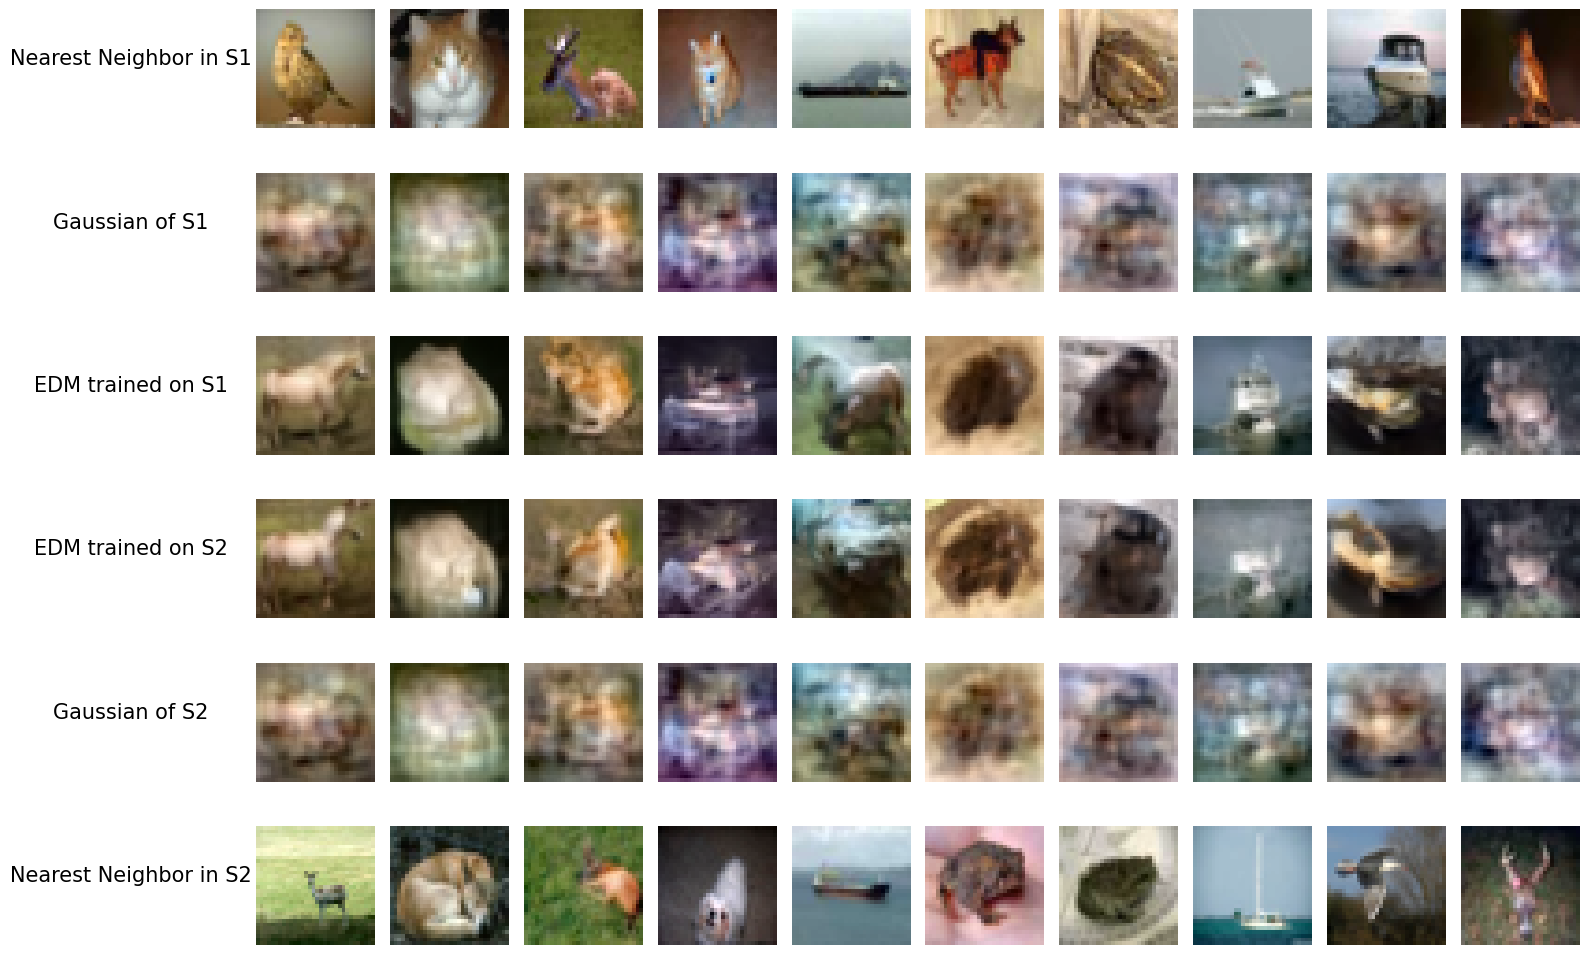

In [52]:
labelpad_value = 90
plt.figure(figsize=(16,10))
#plt.figure(figsize=(20,6))
num_show = 10
idx_list = range(num_show)
fontsize = 15
#idx_list = range(60,70)
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1)
    plt.imshow(normalize_img(nn_25000_s1[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_25000_s1[-4][idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+2*num_show)
    plt.imshow(normalize_img(denoised_25000_s1[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S1', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 

for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+3*num_show)
    plt.imshow(normalize_img(denoised_25000_s2[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+4*num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_25000_s2[-4][idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+5*num_show)
    plt.imshow(normalize_img(nn_25000_s2[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S2',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
plt.tight_layout()

### The results above demonstrate that strong generalizability emerges when training dataset is sufficiently large. Nevertheless, if we decrease the dataset size from 25000 to 782 while using a relatively large model scale 128, diffusion models will enter the memorization regime as shown below

In [71]:
torch.manual_seed(0)
# prepare test image and the noise
device = torch.device('cuda')
data_path_s1 = 'datasets/cifar10-782-set1.zip'
data_path_s2 = 'datasets/cifar10-782-set2.zip'
dataset_s1 = load_ffhq_zip(data_path_s1)
dataset_s2 = load_ffhq_zip(data_path_s2)

net_final_pkl_s1 = 'Strong_Generalization_Weights/Cifar/782-set1-scale-128/network-snapshot-195686.pkl'
net_final_pkl_s2 = 'Strong_Generalization_Weights/Cifar/782-set2-scale-128/network-snapshot-105369.pkl'

# Construct the class for finding nearest neighbors
nn_finder_s1 = KnnFinder(data_path_s1)
nn_finder_s2 = KnnFinder(data_path_s2)

with dnnlib.util.open_url(net_final_pkl_s1) as f:
    net_final_s1 = pickle.load(f)['ema'].to(device)
    
with dnnlib.util.open_url(net_final_pkl_s2) as f:
    net_final_s2 = pickle.load(f)['ema'].to(device)

load ffhq


100%|██████████| 782/782 [00:00<00:00, 35183.87it/s]


load ffhq


100%|██████████| 782/782 [00:00<00:00, 36148.23it/s]


In [72]:
# Construct the Gaussian model from S1
imgs = load_ffhq_zip(data_path_s1)
mean = torch.mean(imgs, dim=0)
temp = imgs-mean
covariance = temp.T@temp/temp.shape[0]
covariance = covariance.to(device)
U,S,Vh = torch.linalg.svd(covariance, full_matrices=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
mean = mean.to(device)


# You can save those data for later use
'''
save_dir = 'Covariance_Cifar/782_s1/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
torch.save(mean, os.path.join(save_dir,'mean.pt'))
torch.save((U,S,Vh), os.path.join(save_dir,'covariance.pt'))
'''

Gaussian_model_s1 = multi_gaussian(mean, (U, S, Vh),3*32*32).to(device)

# Construct the Gaussian model from S2
imgs = load_ffhq_zip(data_path_s2)
mean = torch.mean(imgs, dim=0)
temp = imgs-mean
covariance = temp.T@temp/temp.shape[0]
covariance = covariance.to(device)
U,S,Vh = torch.linalg.svd(covariance, full_matrices=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
mean = mean.to(device)


# You can save those data for later use
'''
save_dir = 'Covariance_Cifar/782_s2/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
torch.save(mean, os.path.join(save_dir,'mean.pt'))
torch.save((U,S,Vh), os.path.join(save_dir,'covariance.pt'))
'''

Gaussian_model_s2 = multi_gaussian(mean, (U, S, Vh),3*32*32).to(device)

In [75]:
device = torch.device('cuda')
torch.manual_seed(0)
latents = torch.randn(10,3,32,32).to(device)
num_steps = 10
rank = 3*32*32

# Generate images with nonlinear diffusion models
sigma_list, intermediates_782_s1, denoised_intermediates_782_s1 = generate_image(net_final_s1, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_782_s2, denoised_intermediates_782_s2 = generate_image(net_final_s2, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)


# Generate images with linear Gaussian diffusion models
sigma_list, intermediates_Gaussian_782_s1, denoised_intermediates_Gaussian_782_s1 = generate_image_Gaussian(net_final_s1, Gaussian_model_s1, latents.reshape(-1,3*32*32) ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_Gaussian_782_s2, denoised_intermediates_Gaussian_782_s2 = generate_image_Gaussian(net_final_s2, Gaussian_model_s2, latents.reshape(-1,3*32*32) ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)


# Finding the nearest neighbors
denoised_782_s1 = torch.stack(denoised_intermediates_782_s1)[-1].cuda()
descending_index, _ = nn_finder_s1(denoised_782_s1, sigma=torch.tensor(1).to(device)) # here sigma is a dummy input, it can be set to any positive value
nn_782_s1 = dataset_s1[descending_index[:,0],:]

denoised_782_s2 = torch.stack(denoised_intermediates_782_s2)[-1].cuda()
descending_index, _ = nn_finder_s2(denoised_782_s2, sigma=torch.tensor(1).to(device))
nn_782_s2 = dataset_s2[descending_index[:,0],:]

100%|██████████| 10/10 [00:00<00:00, 86.67step/s]


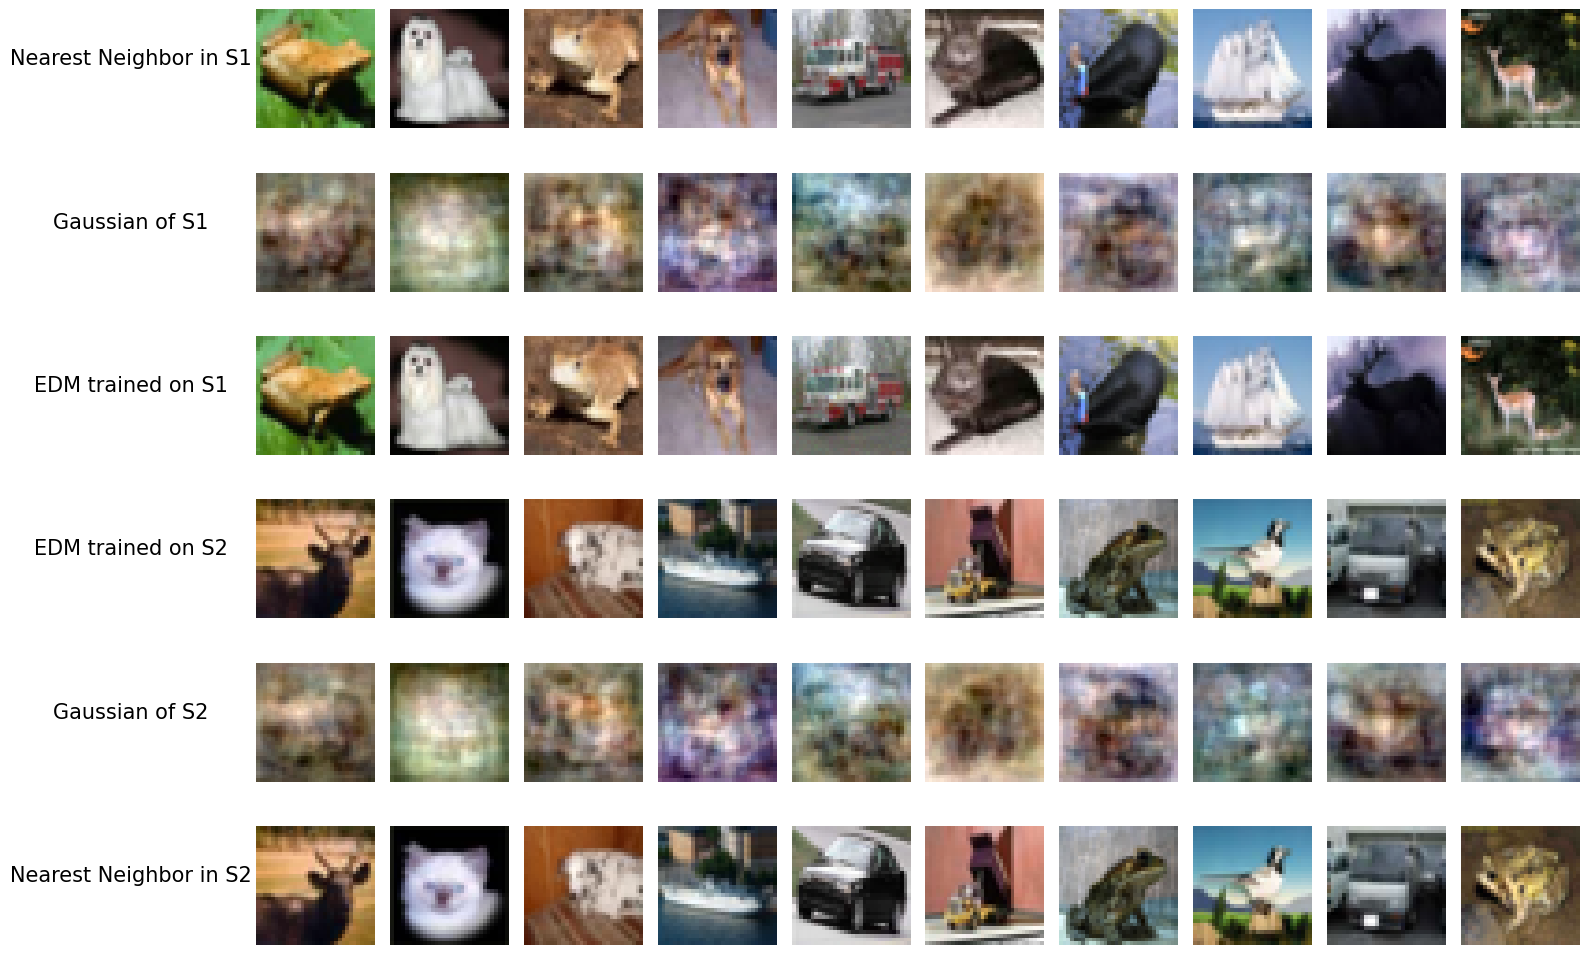

In [77]:
labelpad_value = 90
plt.figure(figsize=(16,10))
num_show = 10
idx_list = range(num_show)
fontsize = 15
#idx_list = range(60,70)
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1)
    plt.imshow(normalize_img(nn_782_s1[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_782_s1[-4][idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+2*num_show)
    plt.imshow(normalize_img(denoised_782_s1[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S1', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 

for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+3*num_show)
    plt.imshow(normalize_img(denoised_782_s2[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+4*num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_782_s2[-4][idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+5*num_show)
    plt.imshow(normalize_img(nn_782_s2[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S2',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
plt.tight_layout()

### Next, we show early stop the training process leads to emergence of Gaussian structure

In [85]:
net_final_pkl_s1 = 'Strong_Generalization_Weights/Cifar/782-set1-scale-128/network-snapshot-000921.pkl'

net_final_pkl_s2 = 'Strong_Generalization_Weights/Cifar/782-set2-scale-128/network-snapshot-000921.pkl'

with dnnlib.util.open_url(net_final_pkl_s1) as f:
    net_final_s1 = pickle.load(f)['ema'].to(device)
    
with dnnlib.util.open_url(net_final_pkl_s2) as f:
    net_final_s2 = pickle.load(f)['ema'].to(device)

In [86]:
device = torch.device('cuda')
torch.manual_seed(0)
latents = torch.randn(10,3,32,32).to(device)
num_steps = 10
rank = 3*32*32

# Generate images with nonlinear diffusion models
sigma_list, intermediates_782_s1, denoised_intermediates_782_s1 = generate_image(net_final_s1, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_782_s2, denoised_intermediates_782_s2 = generate_image(net_final_s2, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)

# Finding the nearest neighbors
denoised_782_s1 = torch.stack(denoised_intermediates_782_s1)[-1].cuda()
descending_index, _ = nn_finder_s1(denoised_782_s1, sigma=torch.tensor(1).to(device)) # here sigma is a dummy input, it can be set to any positive value
nn_782_s1 = dataset_s1[descending_index[:,0],:]

denoised_782_s2 = torch.stack(denoised_intermediates_782_s2)[-1].cuda()
descending_index, _ = nn_finder_s2(denoised_782_s2, sigma=torch.tensor(1).to(device))
nn_782_s2 = dataset_s2[descending_index[:,0],:]

100%|██████████| 10/10 [00:00<00:00, 34.73step/s]


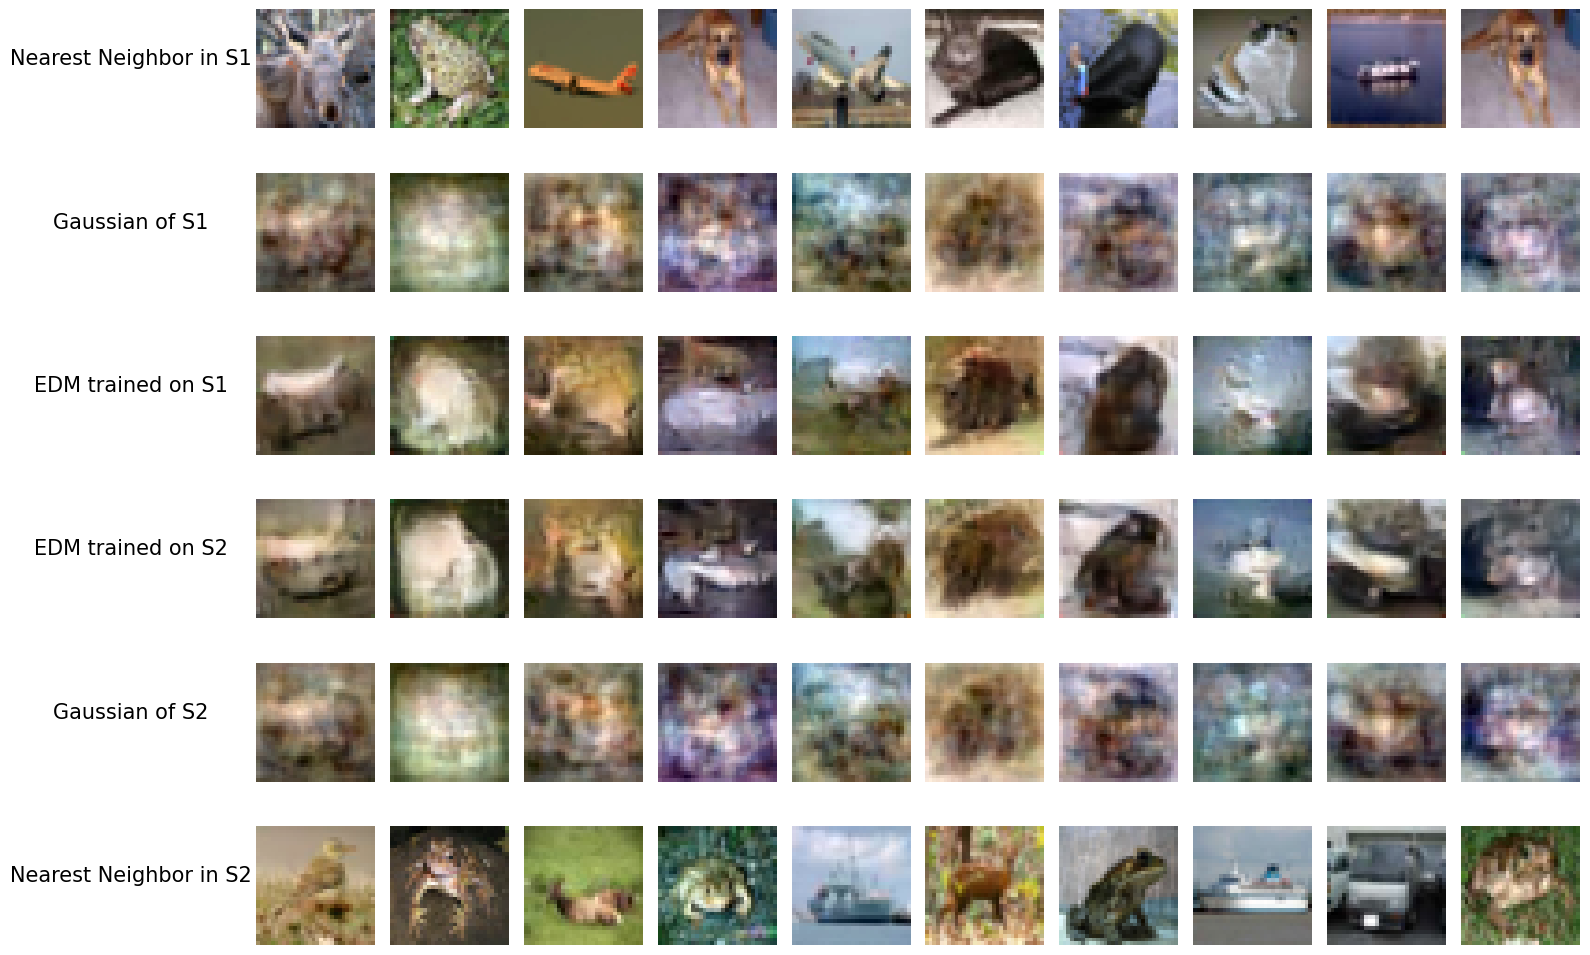

In [87]:
labelpad_value = 90
plt.figure(figsize=(16,10))
num_show = 10
idx_list = range(num_show)
fontsize = 15
#idx_list = range(60,70)
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1)
    plt.imshow(normalize_img(nn_782_s1[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_782_s1[-4][idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+2*num_show)
    plt.imshow(normalize_img(denoised_782_s1[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S1', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 

for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+3*num_show)
    plt.imshow(normalize_img(denoised_782_s2[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+4*num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_782_s2[-4][idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+5*num_show)
    plt.imshow(normalize_img(nn_782_s2[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S2',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
plt.tight_layout()

### On the other hand, decrease model scale from 128 to 4 will prevent models from memorization even if they are trained for suffciently long iterations

In [88]:
net_final_pkl_s1 = 'Strong_Generalization_Weights/Cifar/782-set1-scale-4/network-snapshot-200000.pkl'

net_final_pkl_s2 = 'Strong_Generalization_Weights/Cifar/782-set2-scale-4/network-snapshot-200000.pkl'

with dnnlib.util.open_url(net_final_pkl_s1) as f:
    net_final_s1 = pickle.load(f)['ema'].to(device)
    
with dnnlib.util.open_url(net_final_pkl_s2) as f:
    net_final_s2 = pickle.load(f)['ema'].to(device)

In [89]:
device = torch.device('cuda')
torch.manual_seed(0)
latents = torch.randn(10,3,32,32).to(device)
num_steps = 10
rank = 3*32*32

# Generate images with nonlinear diffusion models
sigma_list, intermediates_782_s1, denoised_intermediates_782_s1 = generate_image(net_final_s1, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_782_s2, denoised_intermediates_782_s2 = generate_image(net_final_s2, latents ,num_steps=num_steps, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)

# Finding the nearest neighbors
denoised_782_s1 = torch.stack(denoised_intermediates_782_s1)[-1].cuda()
descending_index, _ = nn_finder_s1(denoised_782_s1, sigma=torch.tensor(1).to(device)) # here sigma is a dummy input, it can be set to any positive value
nn_782_s1 = dataset_s1[descending_index[:,0],:]

denoised_782_s2 = torch.stack(denoised_intermediates_782_s2)[-1].cuda()
descending_index, _ = nn_finder_s2(denoised_782_s2, sigma=torch.tensor(1).to(device))
nn_782_s2 = dataset_s2[descending_index[:,0],:]

100%|██████████| 10/10 [00:00<00:00, 45.49step/s]


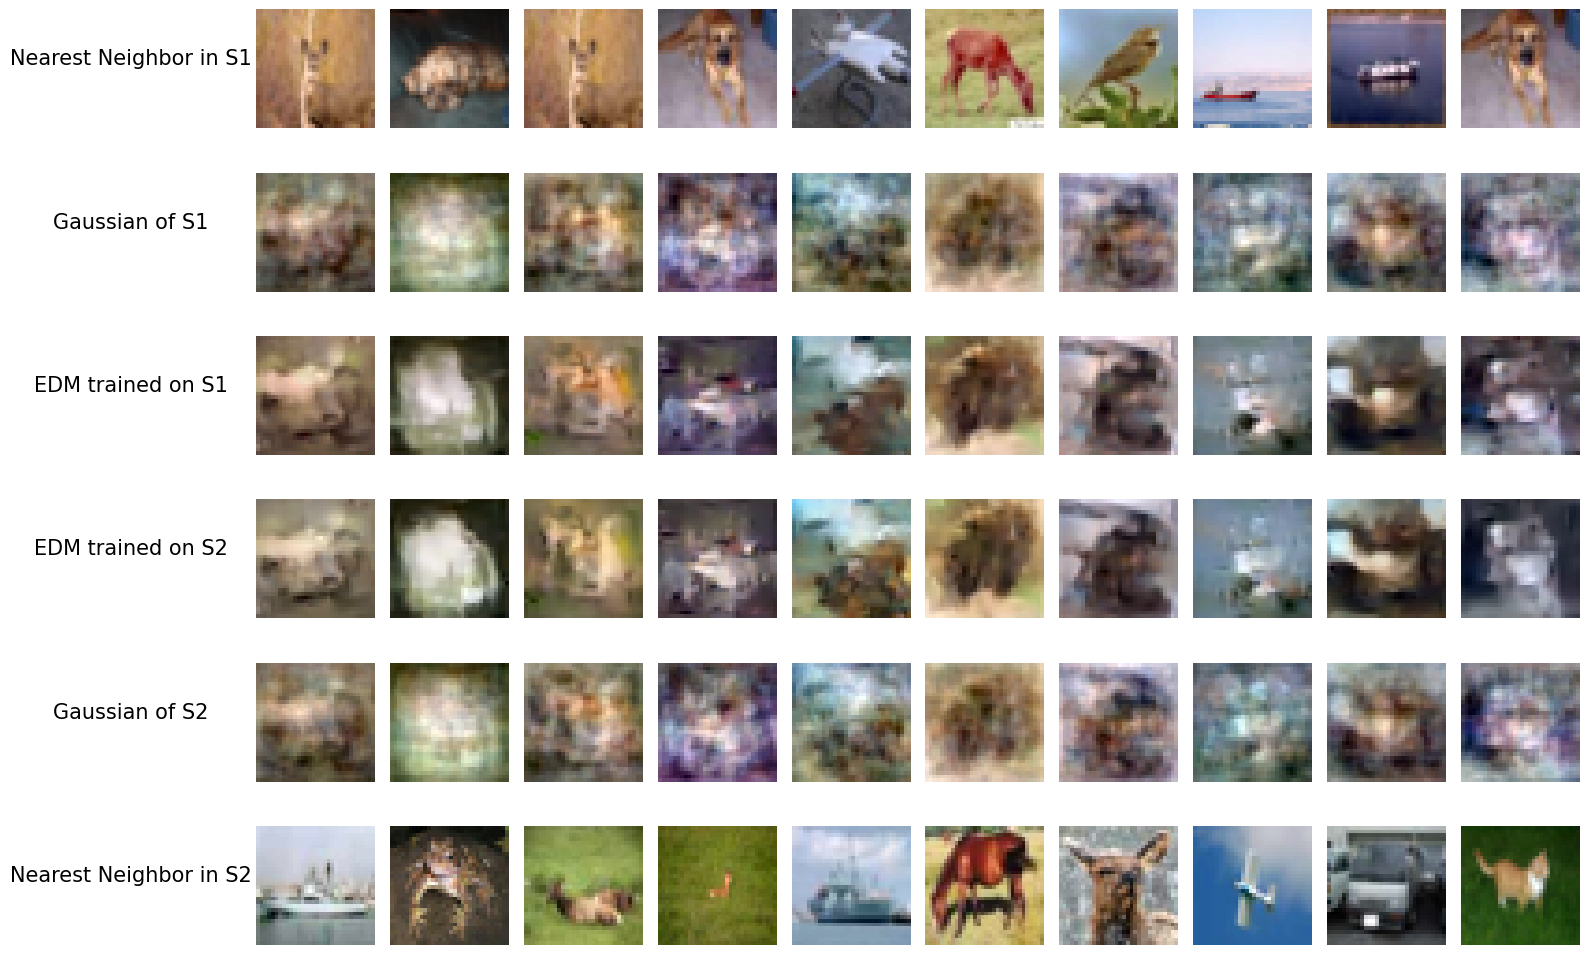

In [90]:
labelpad_value = 90
plt.figure(figsize=(16,10))
num_show = 10
idx_list = range(num_show)
fontsize = 15
#idx_list = range(60,70)
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1)
    plt.imshow(normalize_img(nn_782_s1[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_782_s1[-4][idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S1',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+2*num_show)
    plt.imshow(normalize_img(denoised_782_s1[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S1', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 

for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+3*num_show)
    plt.imshow(normalize_img(denoised_782_s2[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM trained on S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+4*num_show)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian_782_s2[-4][idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian of S2', rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
for i in range(len(idx_list)):
    idx = idx_list[i]
    plt.subplot(6,num_show,i+1+5*num_show)
    plt.imshow(normalize_img(nn_782_s2[idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Nearest Neighbor in S2',rotation=0,labelpad=labelpad_value, fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False)
        
plt.tight_layout()

### Lastly, we'd like to remark that the Gaussian strucure only partially explains the generalization. In the case of Cifar-10, it can not lead to images with semantic meaning. What's beyond the Gaussian structure is an interesting research question.